## Data Treating

In [1]:
# ===========================================
# 0. Enviroment Set-up
# ===========================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib set up
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

In [2]:
# ===========================================
# 1.1 Data Loading
# ===========================================
csv_path = "SPY_2020-07-01_2021-07-01_minute.csv"
df = pd.read_csv(csv_path)

data_raw = df.copy()
data_raw = data_raw.set_index('timestamp')
# data_raw = data_raw.head(10000).set_index('timestamp')

In [3]:
data_raw.head(5)

,open,high,low,close,volume,dollar_volume,tick_count,trade_size_mean,trade_size_std,zero_return_count,price_direction_ratio,large_trade_count,large_trade_volume,vwap,large_trade_ratio,large_trade_volume_ratio
timestamp,,,,,,,,,,,,,,,,
2020-07-01 04:00:00-04:00,308.68,308.84,308.68,308.83,656.0,202545.01,16,41.000000,42.842347,9,0.250000,0,0.0,308.757637,0.0,0.0
2020-07-01 04:01:00-04:00,308.78,308.79,308.74,308.74,2594.0,800940.16,9,288.222222,219.928271,4,0.222222,0,0.0,308.766446,0.0,0.0
2020-07-01 04:02:00-04:00,308.77,308.84,308.77,308.84,807.0,249212.90,4,201.750000,235.213910,2,0.500000,0,0.0,308.814002,0.0,0.0
2020-07-01 04:03:00-04:00,308.82,308.84,308.82,308.84,89.0,27485.78,3,29.666667,9.073772,2,0.333333,0,0.0,308.828989,0.0,0.0
2020-07-01 04:04:00-04:00,308.84,308.90,308.84,308.90,501.0,154738.60,5,100.200000,86.024415,2,0.600000,0,0.0,308.859481,0.0,0.0


In [ ]:
# ===========================================
# 1.2 Labels 
# ===========================================

# ---------- Labels & Forward Log Returns  ----------

H   = 5        # 5 bar lookahead
TAU = 0.01     # 1% threshold

# ★ Log Returns：ln(P_{t+H} / P_t)
fwd_ret_full = np.log(data_raw['close'].shift(-H) / data_raw['close'])

labels = np.select(
    [fwd_ret_full >  TAU,
     fwd_ret_full < -TAU],
    [ 1,              -1],        # Buy=1, Sell=-1
    default = 0
)

labels = pd.Series(labels, index=fwd_ret_full.index)\
           .where(fwd_ret_full.notna())

data_raw['action'] = labels
data_raw = data_raw.dropna(subset=['action'])

In [5]:
data_raw[data_raw['action'] != 0].size

2074

In [38]:
# ===========================================
# 1.3 Features Selection
# ===========================================
from ta.momentum import RSIIndicator

# Define columns for Min-Max normalization
unbounded_features_cols = [
    'open', 'high', 'low', 'close',
    'volume', 'vwap', 'dollar_volume',
    'tick_count', 'trade_size_mean',
    'zero_return_count', 'large_trade_count',
    'large_trade_volume'
]

# features selecting function
def compute_bounded_indicators(
    df: pd.DataFrame,
    unbounded_cols: list[str],
    rsi_period: int = 14
) -> pd.DataFrame:
    """
    For each column in the specified list "unbounded_cols" in df, compute the RSI as a bounded indicator
    and append it as a new column. Automatically drop all initial rows with NaN values due to RSI's rolling
    window computation, and fill any remaining NaNs using linear interpolation.

    Parameters
    ----------
    df : pd.DataFrame
        The original DataFrame, which should contain at least the columns listed in unbounded_cols.
        These columns are assumed to have no missing values initially.
    unbounded_cols : List[str]
        A list of column names for which RSI (bounded indicator) will be computed, e.g.:
        ['open', 'high', 'low', 'close', 'volume', 'vwap', 'dollar_volume',
         'tick_count', 'trade_size_mean', 'zero_return_count',
         'large_trade_count', 'large_trade_volume']
    rsi_period : int, default 14
        The window size for RSI computation. The RSI output range is [0, 100].

    Returns
    ----------
    df_out : pd.DataFrame
        The resulting DataFrame containing all original columns plus RSI columns
        (named "rsi(col)") for each column in unbounded_cols. All leading rows with NaN values
        are dropped, and remaining scattered NaNs are linearly interpolated.
    """

    data = df.copy()

    # 1. Compute RSI for each specified unbounded column
    for col in unbounded_cols:
        # RSIIndicator expects a pd.Series as input
        rsi_obj = RSIIndicator(close=data[col], window=rsi_period)
        data[f"rsi({col})"] = rsi_obj.rsi()

    # 2. Find the first row without any NaN and drop all rows before it
    mask_any_na = data.isna().any(axis=1)
    if mask_any_na.all():
        # If all rows contain NaNs (edge case), return an empty DataFrame with same columns
        return data.iloc[0:0]

    first_valid_idx = mask_any_na.idxmin()  # First False (i.e., no NaN) row index
    data = data.loc[first_valid_idx:].copy()

    # 3. Apply linear interpolation to fill remaining scattered NaNs
    data = data.interpolate(method="linear", limit_direction="forward", axis=0)

    # (Optional) If there are still NaNs at the tail, may choose to backfill:
    # data = data.fillna(method="bfill")

    return data

data_featured = compute_bounded_indicators(data_raw, unbounded_cols=unbounded_features_cols)
data_featured = data_featured.drop(columns=unbounded_features_cols)

In [7]:
data_featured.sample(5)

,trade_size_std,price_direction_ratio,large_trade_ratio,large_trade_volume_ratio,action,rsi(open),rsi(high),rsi(low),rsi(close),rsi(volume),rsi(vwap),rsi(dollar_volume),rsi(tick_count),rsi(trade_size_mean),rsi(zero_return_count),rsi(large_trade_count),rsi(large_trade_volume)
timestamp,,,,,,,,,,,,,,,,,
2021-02-03 14:52:00-05:00,298.552717,0.155738,0.038934,0.287545,0.0,30.540701,30.690816,43.335770,28.887654,48.655215,40.901718,48.652370,48.047046,50.605916,48.469976,51.717569,49.385916
2020-11-17 11:14:00-05:00,138.524830,0.177843,0.045190,0.223103,0.0,68.044964,58.439952,67.279804,64.266244,48.492104,61.401981,48.495983,50.216107,47.984744,50.951840,57.560914,48.085578
2021-03-05 11:24:00-05:00,345.972655,0.168544,0.008850,0.219849,0.0,41.148064,42.749619,30.850988,36.308363,46.082549,38.105728,46.072864,44.758826,49.143813,45.323590,44.910112,47.541848
2021-02-10 11:21:00-05:00,103.567780,0.250000,0.039720,0.220587,0.0,55.888289,53.933513,58.259995,57.417830,43.810064,56.440493,43.814416,43.376321,43.403931,43.982316,48.659118,45.260787
2021-01-12 08:42:00-05:00,73.297377,0.083333,0.000000,0.000000,0.0,46.628118,42.595514,41.035562,38.696758,48.455750,41.639744,48.455406,50.343595,47.847272,50.373062,46.182038,47.405322


In [ ]:
# seperate action_labels for creating y
action_labels = data_featured["action"].values

In [9]:
action_labels

array([0., 0., 0., ..., 0., 0., 0.], shape=(220143,))

In [ ]:
# ===========================================
# 1.4 Standardization + PCA
# ===========================================

# Standardize features to zero mean and unit variance
scaler = StandardScaler()
data_std  = scaler.fit_transform(data_featured)

# Let PCA determine how many principal components are needed to explain ≥90% of the variance
pca_full = PCA().fit(data_std)
cum_var  = np.cumsum(pca_full.explained_variance_ratio_)   # Cumulative explained variance
n_pc     = np.argmax(cum_var >= 0.90) + 1    # First index where cumulative variance ≥ 90%

print(f"{n_pc} principal components are sufficient to explain ≥90% of the variance")

pca = PCA(n_components=n_pc, random_state=42)
data_pca = pca.fit_transform(data_std)

≥90% 方差用 7 个主成分就够了


In [11]:
data_pca.shape

(220143, 7)

In [ ]:
# ===========================================
# 1.5 Discovering Data Patterns
# ===========================================

# KMeans Clustering
scores = {}
for k in range(3, 4):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(data_pca)
    scores[k] = silhouette_score(data_pca, km.labels_)
best_k = max(scores, key=scores.get)
print("Best k (silhouette max) =", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(data_pca)

最佳 k (silhouette max) = 3


In [ ]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_db = dbscan.fit_predict(data_pca)

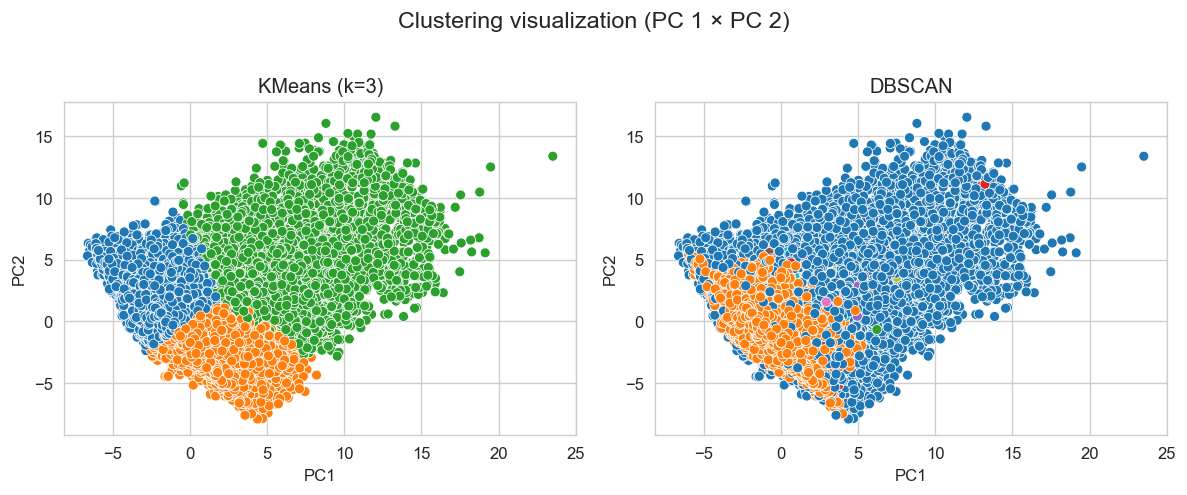

In [ ]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# KMeans
sns.scatterplot(
    x=data_pca[:, 0], y=data_pca[:, 1],
    hue=labels_km.astype(str),
    palette="tab10", ax=axes[0], legend=False
)
axes[0].set_title(f"KMeans (k={best_k})")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")

# DBSCAN
sns.scatterplot(
    x=data_pca[:, 0], y=data_pca[:, 1],
    hue=labels_db.astype(str),
    palette="tab10", ax=axes[1], legend=False
)
axes[1].set_title("DBSCAN")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")

plt.suptitle("Clustering visualization (PC 1 * PC 2)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [15]:
feature_array = data_pca.copy()
target_array = action_labels.copy()
feature_array.shape, target_array.shape

((220143, 7), (220143,))

In [ ]:
# ===========================================
# 1.6 Creating X，y data
# ===========================================

seq_len = 16

n_samples = len(action_labels) - seq_len

X = []
y = []

# Populate X and y using a sliding window
for i in range(n_samples):
    # X[i] = features_array[i : i+seq_len]
    X.append(feature_array[i : i + seq_len, :])
    # y[i] = target_array[i+seq_len]
    y.append(target_array[i + seq_len])

X = np.array(X); y = np.array(y)


In [17]:
X.shape, y.shape

((220127, 16, 7), (220127,))

In [18]:
y[i]

np.float64(0.0)

In [ ]:
train_pct = 0.7
valid_pct = 0.15
test_pct = 0.15

total_len = X.shape[0]

train_len = int(train_pct * total_len)
valid_len = int(valid_pct * total_len)
test_len = int(test_pct * total_len)

X_train = X[:train_len]
X_valid = X[train_len:train_len+valid_len]
X_test = X[train_len+valid_len:]

y_train = y[:train_len]
y_valid = y[train_len:train_len+valid_len]
y_test = y[train_len+valid_len:]


print("X shape:", X_train.shape, X_valid.shape, X_test.shape)
print("y shape:", y_train.shape, y_valid.shape, y_test.shape)


X的尺寸 (154088, 16, 7) (33019, 16, 7) (33020, 16, 7)
y的尺寸 (154088,) (33019,) (33020,)


In [ ]:
# Flatting Data
# Assume X_train.shape == (154088, 16, 7) and y_train.shape == (154088,)
# Reshape X_train from (n_samples, seq_len, n_feats) to (n_samples, seq_len * n_feats)
n_samples, seq_len, n_feats = X_train.shape

X_train_flat = X_train.reshape(n_samples, seq_len * n_feats)
X_valid_flat = X_valid.reshape(X_valid.shape[0], seq_len * n_feats)
X_test_flat  = X_test.reshape(X_test.shape[0],  seq_len * n_feats)

In [21]:
print(X_train.shape)         # (154088, 16, 7)
X_train_flat = X_train.reshape(n_samples, seq_len * n_feats)
print(X_train.shape)         # 仍然是 (154088, 16, 7)
print(X_train_flat.shape)    # (154088, 112)

(154088, 16, 7)
(154088, 16, 7)
(154088, 112)


## Model Building - FROM LIAO ZIYU

#### 2d model

In [22]:
# 0 Prereqs – keep these in one cell
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.linear_model   import LogisticRegression
from sklearn.svm            import LinearSVC
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.ensemble       import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (accuracy_score, f1_score,
                             classification_report, confusion_matrix)

plt.rcParams['figure.dpi'] = 120
sns.set_style('whitegrid')

In [23]:
# 1 Pick up the arrays you already built

# !! run AFTER you executed your preprocessing block !!
# X_train_flat, X_valid_flat, X_test_flat, y_train, y_test already exist

# # optional: merge train+valid for more data
# X_tr   = np.vstack([X_train_flat, X_valid_flat])
# y_tr   = np.concatenate([y_train,  y_valid])

idx_all   = data_featured.index[seq_len:]  

idx_all   = data_featured.index[seq_len:]               # timeline after windowing
idx_test  = idx_all[len(y_train)+len(y_valid):]         # align with y_test

In [24]:
# 2 Model zoo (6 total)

sk_models = {
    "LogReg-Softmax": LogisticRegression(
        multi_class='multinomial', class_weight='balanced',
        max_iter=400, n_jobs=-1, C=1.0, solver='lbfgs'),

    "Linear-SVM":     LinearSVC(class_weight='balanced', C=1.0),

    "k-NN (k=15)":    KNeighborsClassifier(n_neighbors=15, weights='distance'),

    "Random Forest":  RandomForestClassifier(
        n_estimators=400, min_samples_leaf=25,
        n_jobs=-1, random_state=42),

    "Hist GBDT":      HistGradientBoostingClassifier(
        max_depth=4, learning_rate=0.05, max_iter=600,
        class_weight='balanced', random_state=42),

    "2-Layer MLP":    MLPClassifier(hidden_layer_sizes=(128, 64),
        activation='relu', batch_size=2**12, early_stopping=True,
        alpha=1e-4, random_state=42)
}

In [25]:
# 3 Fit → predict → collect metrics

metric_rows, cmaps = [], {}
for name, clf in sk_models.items():
    clf.fit(X_train_flat, y_train)
    y_pred = clf.predict(X_test_flat)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='macro')
    metric_rows.append({"model": name, "accuracy": acc, "macro_F1": f1})

    cmaps[name] = confusion_matrix(y_test, y_pred,
                                   labels=[-1, 0, 1], normalize='true')

    print(f"\n{name}\n" + classification_report(y_test, y_pred, digits=3))

metric_df = pd.DataFrame(metric_rows).set_index("model").round(3)
display(metric_df)

/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



LogReg-Softmax
              precision    recall  f1-score   support

        -1.0      0.001     1.000     0.002         2
         0.0      1.000     0.895     0.944     33015
         1.0      0.001     0.333     0.001         3

    accuracy                          0.895     33020
   macro avg      0.334     0.743     0.316     33020
weighted avg      1.000     0.895     0.944     33020


Linear-SVM
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     0.989     0.994     33015
         1.0      0.006     0.333     0.013         3

    accuracy                          0.988     33020
   macro avg      0.335     0.441     0.336     33020
weighted avg      1.000     0.988     0.994     33020


k-NN (k=15)
              precision    recall  f1-score   support

        -1.0      0.500     0.500     0.500         2
         0.0      1.000     1.000     1.000     33015
         1.0      1.000     0.333 

/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


Random Forest
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     1.000     1.000     33015
         1.0      0.000     0.000     0.000         3

    accuracy                          1.000     33020
   macro avg      0.333     0.333     0.333     33020
weighted avg      1.000     1.000     1.000     33020


Hist GBDT
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     0.972     0.986     33015
         1.0      0.012     0.333     0.023         3

    accuracy                          0.972     33020
   macro avg      0.337     0.435     0.336     33020
weighted avg      1.000     0.972     0.986     33020


2-Layer MLP
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     1.000     1.000     33015
         1.0      0.000     0.000   

/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

,accuracy,macro_F1
model,,
LogReg-Softmax,0.895,0.316
Linear-SVM,0.988,0.336
k-NN (k=15),1.000,0.667
Random Forest,1.000,0.333
Hist GBDT,0.972,0.336
2-Layer MLP,1.000,0.333


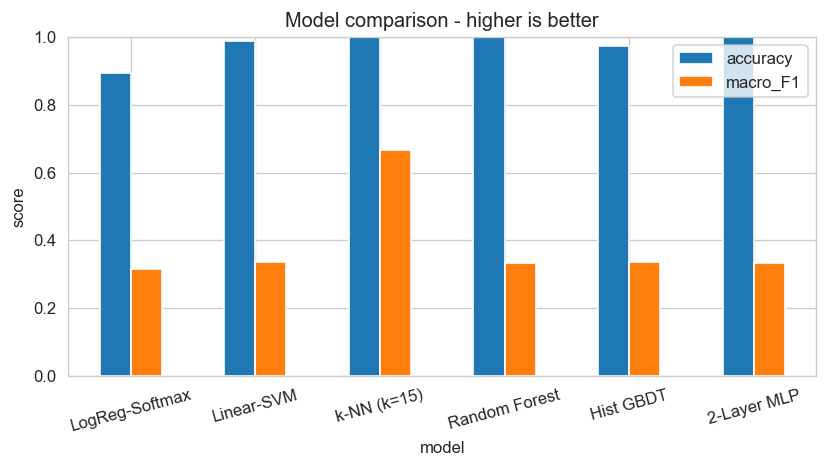

In [26]:
# 4 Visual summaries

# 4-A Accuracy vs. macro-F1
metric_df.plot(kind='bar', figsize=(7,4), rot=15, ylim=(0,1),
               title="Model comparison - higher is better")
plt.ylabel("score"); plt.tight_layout(); plt.show()

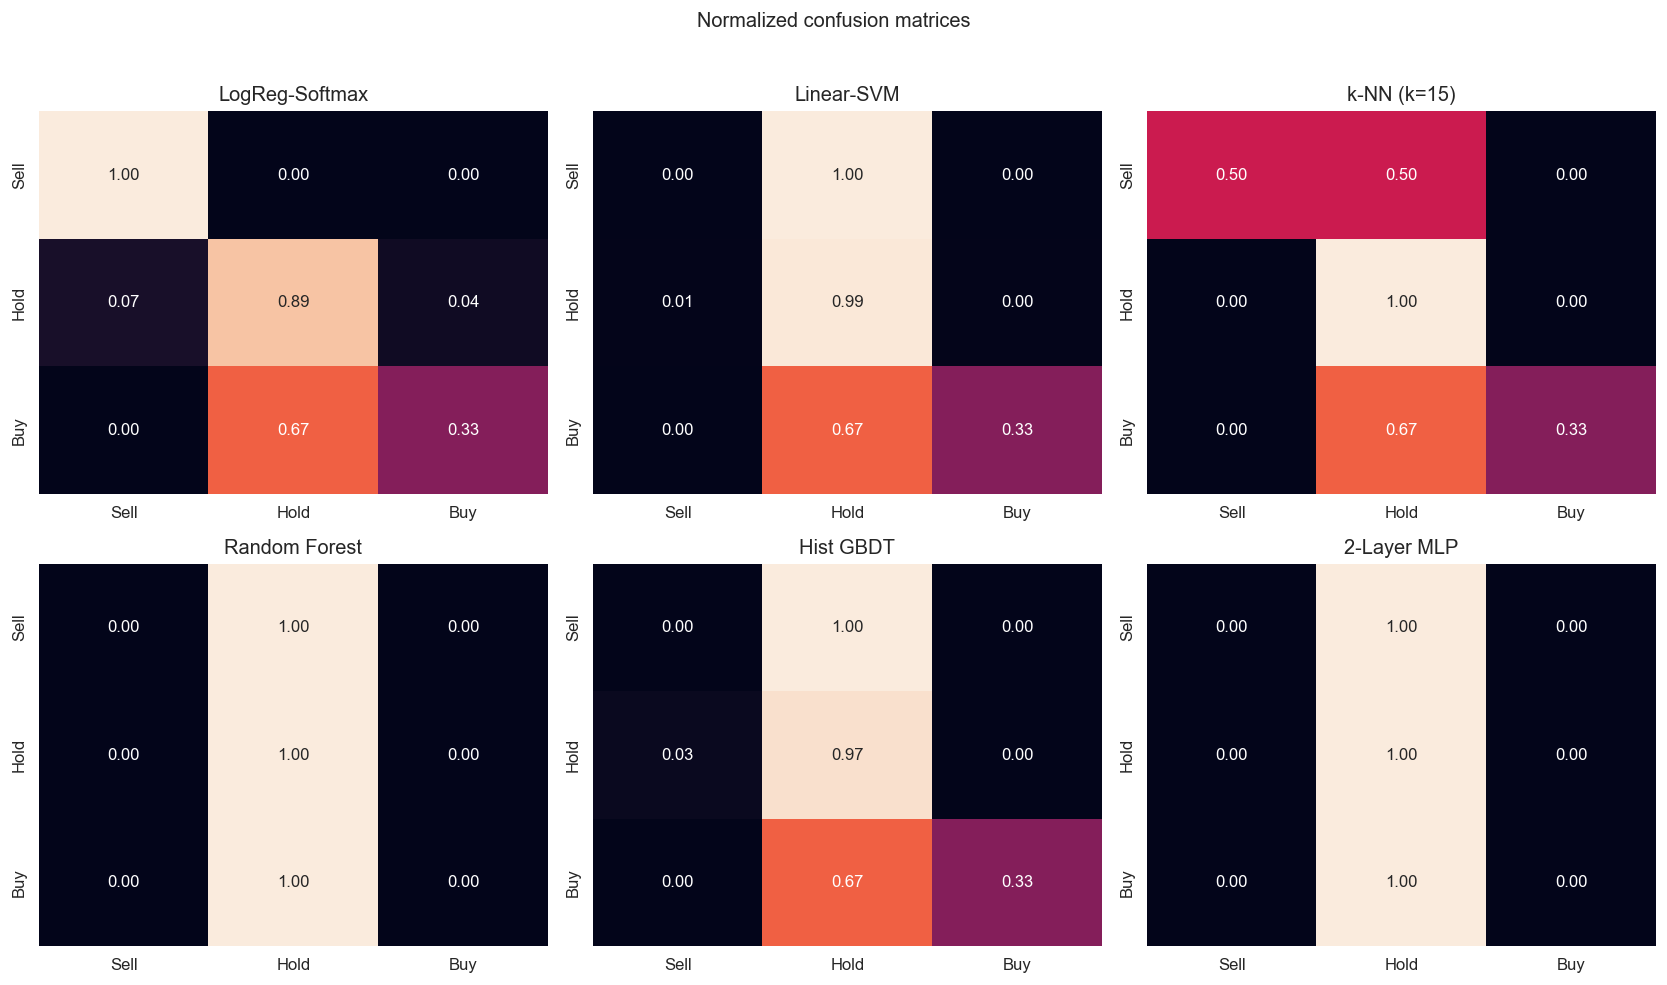

In [27]:
# 4-B Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(14,8))
for ax, (name, cm) in zip(axes.ravel(), cmaps.items()):
    sns.heatmap(cm, annot=True, fmt=".2f", cbar=False,
                xticklabels=["Sell","Hold","Buy"],
                yticklabels=["Sell","Hold","Buy"], ax=ax)
    ax.set_title(name)
plt.suptitle("Normalized confusion matrices", y=1.02)
plt.tight_layout(); plt.show()

/var/folders/mh/pbgs4l0n1md9_5k62z5kmr980000gn/T/ipykernel_8401/2996498548.py:15: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)   # 1-min bars? adapt if 5-min
/var/folders/mh/pbgs4l0n1md9_5k62z5kmr980000gn/T/ipykernel_8401/2996498548.py:15: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)   # 1-min bars? adapt if 5-min


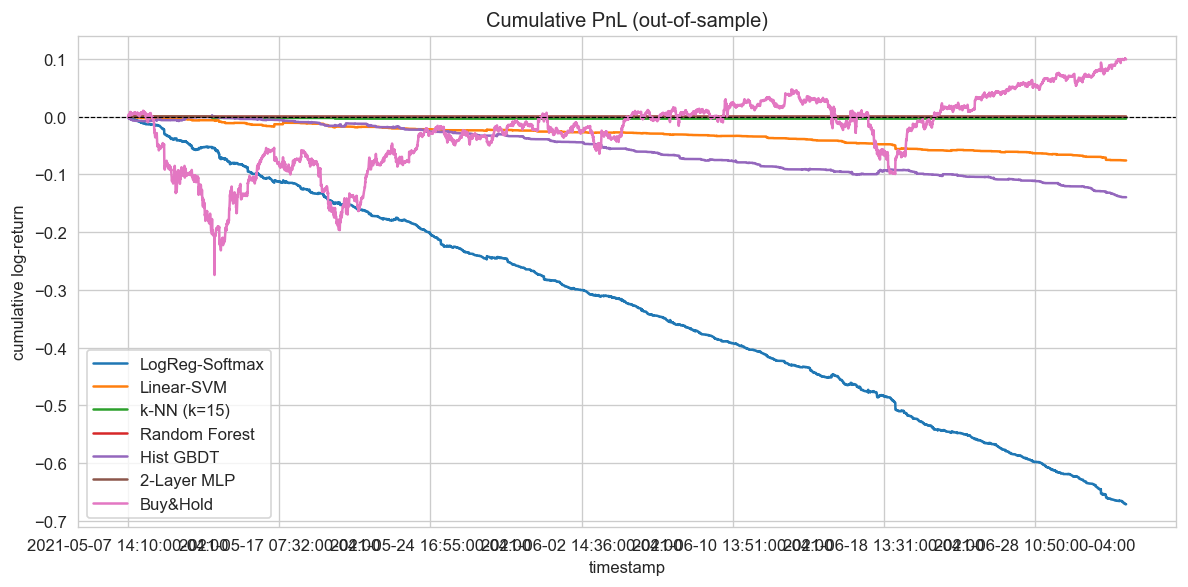

,Sharpe
LogReg-Softmax,-37.90
Linear-SVM,-12.48
k-NN (k=15),-2.54
Random Forest,NaN
Hist GBDT,-16.13
2-Layer MLP,NaN
Buy&Hold,1.21


In [28]:
# 5 Back-test – every model plus Buy & Hold
def backtest(pred, ret, fee_bp=1):
    gross = pred.shift(1) * ret           # enter next bar
    fee   = (pred.diff().abs() > 0).astype(int) * fee_bp/1e4
    return gross - fee

# realised forward log-return you already made
ret_test = fwd_ret_full.loc[idx_test]     # align to y_test timeline

pnl_curves, sharpes = {}, {}
for name, clf in sk_models.items():
    pred = pd.Series(clf.predict(X_test_flat), index=idx_test, name=name)
    pnl  = backtest(pred, ret_test)
    pnl_curves[name] = pnl.cumsum()
    sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)   # 1-min bars? adapt if 5-min

# --- Buy & Hold baseline ---
bh_pred = pd.Series(1, index=idx_test, name="Buy&Hold")
pnl_bh  = backtest(bh_pred, ret_test, fee_bp=0)             # no fee for hold
pnl_curves["Buy&Hold"] = pnl_bh.cumsum()
sharpes["Buy&Hold"]    = pnl_bh.mean()/pnl_bh.std()*np.sqrt(252*390)

# --- plot curves -----------------------------------------------------------
pd.DataFrame(pnl_curves).plot(figsize=(10,5))
plt.axhline(0, ls='--', lw=0.7, c='k')
plt.title("Cumulative PnL (out-of-sample)")
plt.ylabel("cumulative log-return")
plt.tight_layout()
plt.show()

# --- Sharpe table ----------------------------------------------------------
sharpe_tbl = pd.Series(sharpes).round(2).rename("Sharpe").to_frame()
display(sharpe_tbl)


#### 3d model

In [29]:
import numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ❶ map {-1,0,1} → {0,1,2} for soft-max
label_map  = {-1:0, 0:1, 1:2}
inv_map    = {v:k for k,v in label_map.items()}

y_train_int = np.vectorize(label_map.get)(y_train)
y_valid_int = np.vectorize(label_map.get)(y_valid)
y_test_int  = np.vectorize(label_map.get)(y_test)

Model A — 1-D CNN

In [30]:
def make_cnn(seq_len=16, n_feats=7, n_classes=3):
    m = models.Sequential([
        layers.Input(shape=(seq_len, n_feats)),
        layers.Conv1D(64, 3, padding="causal", activation="relu"),
        layers.Conv1D(64, 3, padding="causal", activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(32, activation="relu"),
        layers.Dense(n_classes, activation="softmax")
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

cnn = make_cnn()
hist = cnn.fit(X_train, y_train_int,
               epochs=15, batch_size=2048,
               validation_data=(X_valid, y_valid_int),
               callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
               verbose=2)


Epoch 1/15
76/76 - 2s - 22ms/step - accuracy: 0.9867 - loss: 0.1163 - val_accuracy: 0.9998 - val_loss: 0.0042
Epoch 2/15
76/76 - 1s - 18ms/step - accuracy: 0.9993 - loss: 0.0096 - val_accuracy: 0.9998 - val_loss: 0.0039
Epoch 3/15
76/76 - 1s - 18ms/step - accuracy: 0.9993 - loss: 0.0086 - val_accuracy: 0.9998 - val_loss: 0.0037
Epoch 4/15
76/76 - 1s - 18ms/step - accuracy: 0.9993 - loss: 0.0079 - val_accuracy: 0.9998 - val_loss: 0.0034
Epoch 5/15
76/76 - 1s - 18ms/step - accuracy: 0.9993 - loss: 0.0074 - val_accuracy: 0.9998 - val_loss: 0.0033
Epoch 6/15
76/76 - 1s - 17ms/step - accuracy: 0.9993 - loss: 0.0072 - val_accuracy: 0.9998 - val_loss: 0.0032
Epoch 7/15
76/76 - 1s - 19ms/step - accuracy: 0.9993 - loss: 0.0071 - val_accuracy: 0.9998 - val_loss: 0.0031
Epoch 8/15
76/76 - 1s - 18ms/step - accuracy: 0.9993 - loss: 0.0068 - val_accuracy: 0.9998 - val_loss: 0.0031
Epoch 9/15
76/76 - 1s - 17ms/step - accuracy: 0.9993 - loss: 0.0067 - val_accuracy: 0.9998 - val_loss: 0.0030
Epoch 10/1

Model B — GRU (or LSTM)

In [31]:
def make_gru(seq_len=16, n_feats=7, n_classes=3):
    m = models.Sequential([
        layers.Input(shape=(seq_len, n_feats)),
        layers.GRU(64, return_sequences=False),
        layers.Dense(32, activation="relu"),
        layers.Dense(n_classes, activation="softmax")
    ])
    m.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

gru = make_gru()
hist_g = gru.fit(X_train, y_train_int,
                 epochs=15, batch_size=2048,
                 validation_data=(X_valid, y_valid_int),
                 callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
                 verbose=2)


Epoch 1/15
76/76 - 5s - 62ms/step - accuracy: 0.9583 - loss: 0.2593 - val_accuracy: 0.9998 - val_loss: 0.0026
Epoch 2/15
76/76 - 4s - 55ms/step - accuracy: 0.9993 - loss: 0.0048 - val_accuracy: 0.9998 - val_loss: 0.0025
Epoch 3/15
76/76 - 4s - 57ms/step - accuracy: 0.9993 - loss: 0.0044 - val_accuracy: 0.9998 - val_loss: 0.0024
Epoch 4/15
76/76 - 4s - 58ms/step - accuracy: 0.9993 - loss: 0.0042 - val_accuracy: 0.9998 - val_loss: 0.0023
Epoch 5/15
76/76 - 4s - 54ms/step - accuracy: 0.9994 - loss: 0.0041 - val_accuracy: 0.9998 - val_loss: 0.0023
Epoch 6/15
76/76 - 4s - 58ms/step - accuracy: 0.9994 - loss: 0.0041 - val_accuracy: 0.9998 - val_loss: 0.0022
Epoch 7/15
76/76 - 4s - 57ms/step - accuracy: 0.9994 - loss: 0.0040 - val_accuracy: 0.9998 - val_loss: 0.0022
Epoch 8/15
76/76 - 4s - 53ms/step - accuracy: 0.9994 - loss: 0.0039 - val_accuracy: 0.9998 - val_loss: 0.0021
Epoch 9/15
76/76 - 4s - 56ms/step - accuracy: 0.9994 - loss: 0.0039 - val_accuracy: 0.9997 - val_loss: 0.0021
Epoch 10/1

In [32]:
# Convert predictions back to {-1, 0, 1}
def keras_predict_to_series(model, X, idx):
    probs   = model.predict(X, verbose=0)
    y_hat_i = probs.argmax(axis=1)           # {0,1,2}
    y_hat   = np.vectorize(inv_map.get)(y_hat_i)
    return pd.Series(y_hat, index=idx)

pred_cnn = keras_predict_to_series(cnn, X_test,  idx_test)
pred_gru = keras_predict_to_series(gru, X_test,  idx_test)


In [33]:
# Evaluation block (reuse everything)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- helper to append ------------------------------------------------------
def eval_and_store(name, pred_series):
    y_pred = pred_series.values
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='macro')

    metric_df.loc[name] = [acc, f1]          # add new row
    cmaps[name] = confusion_matrix(y_test, y_pred,
                                   labels=[-1,0,1], normalize='true')

    print(f"\n{name}\n" + classification_report(y_test, y_pred, digits=3))

    pnl = backtest(pred_series, fwd_ret_full.loc[pred_series.index])
    pnl_curves[name] = pnl.cumsum()
    sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)

# --- evaluate the two deep models -----------------------------------------
eval_and_store("CNN-1d", pred_cnn)
eval_and_store("GRU",    pred_gru)


CNN-1d
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     1.000     1.000     33015
         1.0      0.000     0.000     0.000         3

    accuracy                          1.000     33020
   macro avg      0.333     0.333     0.333     33020
weighted avg      1.000     1.000     1.000     33020


GRU
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     1.000     1.000     33015
         1.0      0.000     0.000     0.000         3

    accuracy                          1.000     33020
   macro avg      0.333     0.333     0.333     33020
weighted avg      1.000     1.000     1.000     33020



/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [34]:
metric_df.sort_values("macro_F1", ascending=False, inplace=True)
display(metric_df.round(3))          # updated table

# bar-plot, confusion-matrix grid, PnL curve, Sharpe table:
#   (reuse the same code blocks as before)

,accuracy,macro_F1
model,,
k-NN (k=15),1.000,0.667
Linear-SVM,0.988,0.336
Hist GBDT,0.972,0.336
CNN-1d,1.000,0.333
GRU,1.000,0.333
Random Forest,1.000,0.333
2-Layer MLP,1.000,0.333
LogReg-Softmax,0.895,0.316


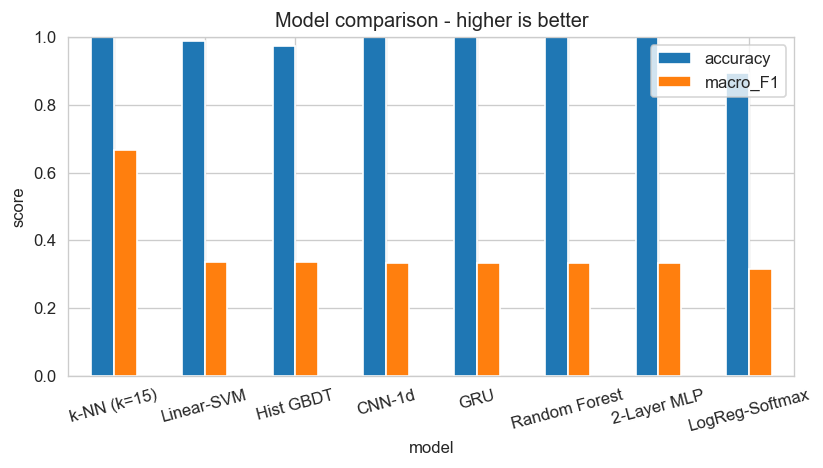

In [35]:
metric_df.plot(kind='bar', figsize=(7,4), rot=15, ylim=(0,1),
               title="Model comparison - higher is better")
plt.ylabel("score"); plt.tight_layout(); plt.show()

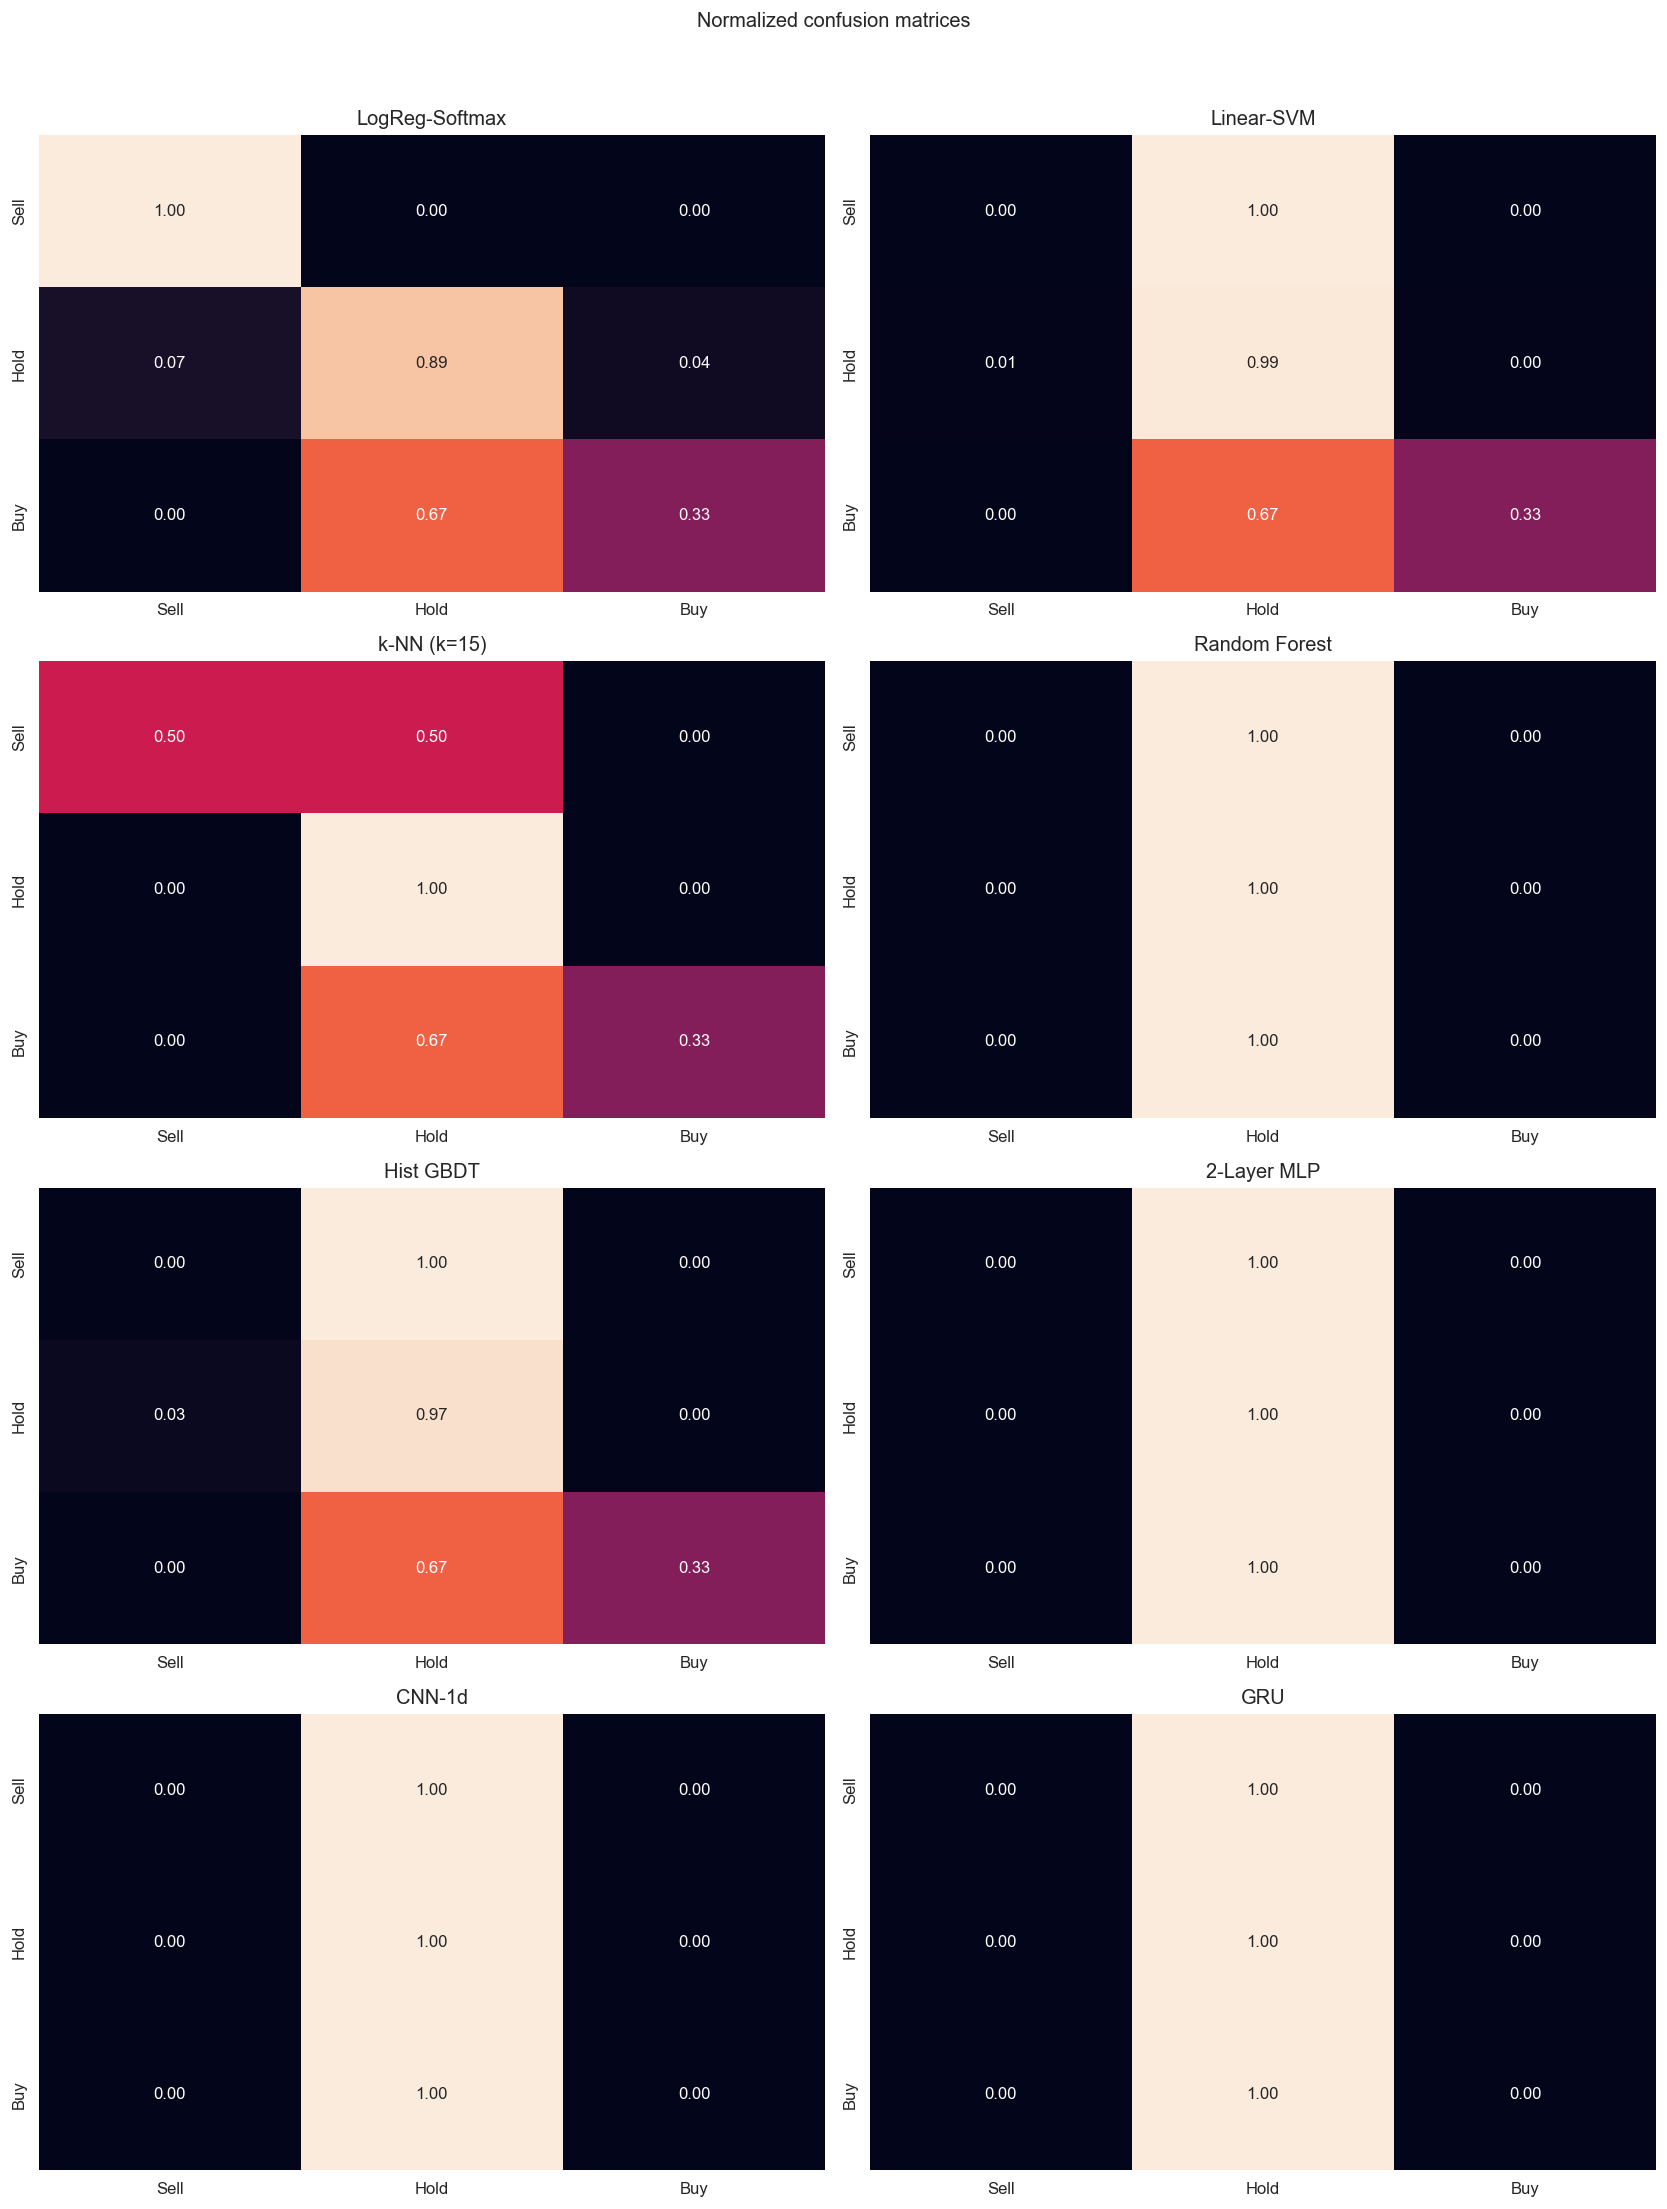

In [36]:
fig, axes = plt.subplots(4, 2, figsize=(14,18))
for ax, (name, cm) in zip(axes.ravel(), cmaps.items()):
    sns.heatmap(cm, annot=True, fmt=".2f", cbar=False,
                xticklabels=["Sell","Hold","Buy"],
                yticklabels=["Sell","Hold","Buy"], ax=ax)
    ax.set_title(name)
plt.suptitle("Normalized confusion matrices", y=1.02)
plt.tight_layout(); plt.show()

/var/folders/mh/pbgs4l0n1md9_5k62z5kmr980000gn/T/ipykernel_8401/4167790060.py:12: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)
/var/folders/mh/pbgs4l0n1md9_5k62z5kmr980000gn/T/ipykernel_8401/4167790060.py:12: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)
/var/folders/mh/pbgs4l0n1md9_5k62z5kmr980000gn/T/ipykernel_8401/4167790060.py:18: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)


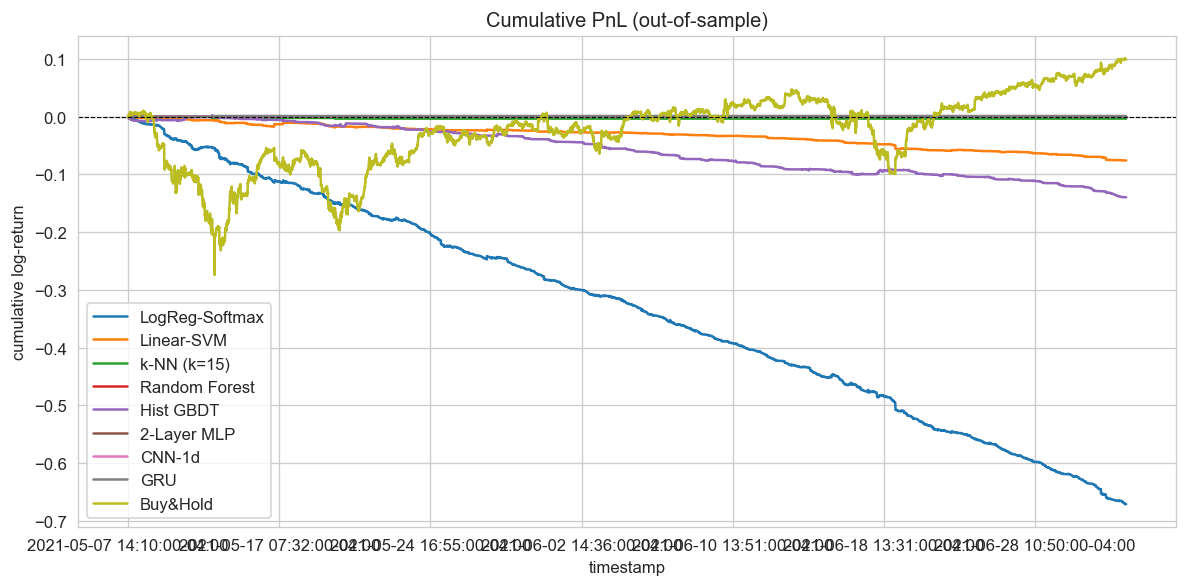

,Sharpe
LogReg-Softmax,-37.90
Linear-SVM,-12.48
k-NN (k=15),-2.54
Random Forest,NaN
Hist GBDT,-16.13
2-Layer MLP,NaN
CNN-1d,NaN
GRU,1.58
Buy&Hold,1.21


In [37]:
# realised forward log-return you already made
ret_test = fwd_ret_full.loc[idx_test]     # align to y_test timeline

# ---------- 回测 ----------
pnl_curves, sharpes = {}, {}

# 2-D scikit-learn 模型
for name, clf in sk_models.items():
    pred = pd.Series(clf.predict(X_test_flat), index=idx_test, name=name)
    pnl  = backtest(pred, ret_test)
    pnl_curves[name] = pnl.cumsum()
    sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)

# 3-D 深度模型
for name, pred in [("CNN-1d", pred_cnn), ("GRU", pred_gru)]:
    pnl  = backtest(pred, ret_test)
    pnl_curves[name] = pnl.cumsum()
    sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)

# --- Buy & Hold baseline ---
bh_pred = pd.Series(1, index=idx_test, name="Buy&Hold")
pnl_bh  = backtest(bh_pred, ret_test, fee_bp=0)             # no fee for hold
pnl_curves["Buy&Hold"] = pnl_bh.cumsum()
sharpes["Buy&Hold"]    = pnl_bh.mean()/pnl_bh.std()*np.sqrt(252*390)

# --- plot curves -----------------------------------------------------------
pd.DataFrame(pnl_curves).plot(figsize=(10,5))
plt.axhline(0, ls='--', lw=0.7, c='k')
plt.title("Cumulative PnL (out-of-sample)")
plt.ylabel("cumulative log-return")
plt.tight_layout()
plt.show()

# --- Sharpe table ----------------------------------------------------------
sharpe_tbl = pd.Series(sharpes).round(2).rename("Sharpe").to_frame()
display(sharpe_tbl)
